In [1]:
import time
import warnings

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from typing import List

from pyROMs import POD, DMD, PartitionedDMD
from readers import NeutronicsDatasetReader

from utils import *

warnings.filterwarnings('ignore')

Define Routines

In [29]:
def few_snapshot_validation(pod, X, Y):
    """
    Perform few snapshot validation.

    Parameters
    ----------
    pod : POD
    X : The simulation data.
    Y : The corresponding parameters.
    """
    try:
        for i in range(1, 3):
            print(f"{i} snapshot validation test...")
            x = np.atleast_2d(X[0:i]).reshape(i, -1)
            y = np.atleast_2d(Y[0:i]).reshape(i, -1)
            pod.fit(x, y)
            x_pod = pod.predict(y)
            error = norm(x - x_pod) / norm(x)
            print(f"Error:\t{error:.3e}\n")
    except BaseException as err:
        pass


def plot_pod_errors(times, pod_errors,
                    title=None, xlabel=None):
    """
    Plot the POD time step errors as a function of time.

    Parameters
    ----------
    times : numpy.ndarray
    pod_errors : numpy.ndarray
    title : str
    xlabel : str
    """
    title = "Worst Result" if title is None else title
    xlabel = "Time (s)" if xlabel is None else xlabel

    plt.figure()
    plt.tick_params(labelsize=12)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("$L^2$ Error", fontsize=12)
    plt.semilogy(times, pod_errors, '-*b')
    plt.grid(True)
    plt.tight_layout()


def plot_dmd_errors(times, pod_errors, dmd_errors,
                    reconstruction_errors,
                    title=None, xlabel=None):
    """
    Plot the POD time step errors as a function of time.

    Parameters
    ----------
    times : numpy.ndarray
    pod_errors : numpy.ndarray
    dmd_errors : numpy.ndarray
    reconstruction_errors : numpy.ndarray
    title : str
    xlabel : str
    """
    xlabel = "Time (s)" if xlabel is None else xlabel

    plt.figure()
    plt.tick_params(labelsize=12)
    plt.xlabel(f"Time {xlabel}", fontsize=12)
    plt.ylabel("$L^2$ Error", fontsize=12)
    plt.semilogy(times, pod_errors, '-*b', label="POD-MCI")
    plt.semilogy(times, dmd_errors, '-or', ms=2.5, label="DMD")
    plt.semilogy(times, reconstruction_errors, '-+k',
                 label="DMD Reconstruction")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

Parse the Data


In [30]:
problem_name = input("What problem? ")

print("Loading and formating the data...")
t_start = time.time()
dataset = get_data(problem_name)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")


Loading and formating the data...
Loading the data took 12.515788 s


Parameter Definitions and Validation


In [35]:
interior_only = False
test_size = 0.2
seed = 12

params = get_params(problem_name)
vars = params["vars"]
tau = params["tau"]
interp = params["interp"]
epsilon = params["epsilon"]

interp = 'rbf_gaussian'

X = dataset.create_dataset_matrix(vars)
Y = dataset.parameters

pod = POD(-1, interp, epsilon)
few_snapshot_validation(pod, X, Y)


1 snapshot validation test...
Error:	8.347e-17

2 snapshot validation test...
Error:	1.696e-15



Construct the ROM

In [36]:
splits = dataset.train_test_split(variables=vars,
                                  test_size=test_size, seed=seed,
                                  interior_only=interior_only)
X_train, X_test, Y_train, Y_test = splits

print(f"Constructing the ROM...")
t_start = time.time()
pod = POD(1.0 - tau, interp, epsilon)
pod.fit(X_train, Y_train)
t_end = time.time()
pod.print_summary(skip_line=True)
print(f"\nConstruction took {t_end - t_start:.3e} s")

Constructing the ROM...

===== POD Summary =====
# of Modes          : 19
# of Snapshots      : 51
Reconstruction Error: 7.752e-05
Mean Snapshot Error : 7.929e-05
Max Snapshot Error  : 1.687e-04

Construction took 3.007e-02 s


Make Preditctions


Predicting Results with the ROM...
Average prediction time was 8.192e-05 s

===== Summary of 13 POD Queries =====
Number of Snapshots:     	51
Number of POD Modes:     	19
Average POD Error        	4.752e-03
Maximum POD Error:       	1.067e-02
Minimum POD Error:       	1.374e-03


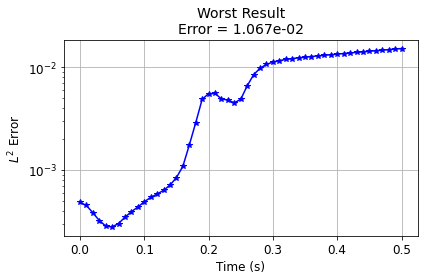

In [37]:
print(f"\nPredicting Results with the ROM...")
t_start = time.time()
X_pod = pod.predict(Y_test)
t_end = time.time()
print(f"Average prediction time was "
      f"{(t_end-t_start)/len(X_pod):.3e} s")

# Unstack vectors
X_test = dataset.unstack_simulation_vector(X_test)
X_pod = dataset.unstack_simulation_vector(X_pod)

# Compute errors
pod_errors = np.zeros(len(X_pod))
for i in range(len(X_pod)):
    pod_errors[i] = norm(X_pod[i]-X_test[i])/norm(X_test[i])

# Compute and plot time step errors
start, end = 0, X_pod.shape[1]
argmax = np.argmax(pod_errors)
x_test, x_pod = X_test[argmax], X_pod[argmax]
pod_step_errors = norm(x_test-x_pod, axis=1)/norm(x_test, axis=1)

title = f"Worst Result\nError = {pod_errors[argmax]:.3e}"
xlabel = "($\mu$s)" if "sphere" in problem_name else "(s)"
plot_pod_errors(dataset.times, pod_step_errors,
                title=title, xlabel=f"Time {xlabel}")

msg = f"===== Summary of {len(pod_errors)} POD Queries ====="
header = "=" * len(msg)
print("\n".join(["", header, msg, header]))
print(f"{'Number of Snapshots:':<25}\t{len(X_train)}")
print(f"{'Number of POD Modes:':<25}\t{pod.n_modes}")
print(f"{'Average POD Error':<25}\t{np.mean(pod_errors):.3e}")
print(f"{'Maximum POD Error:':<25}\t{np.max(pod_errors):.3e}")
print(f"{'Minimum POD Error:':<25}\t{np.min(pod_errors):.3e}")

if 'lra' in problem_name:
    start, end = 120, 160

    # Find peak power arg
    peak_argmax = np.argmax(np.sum(x_pod, axis=1))
    peak_error = norm(x_test[peak_argmax]-x_pod[peak_argmax])
    peak_error /= norm(x_test[peak_argmax])
    print(f"\nError in Peak Power Profile:\t{peak_error:3e}")

    # Plot max power density
    fig: Figure = plt.figure(figsize=(8, 4))
    P_max_test, P_max_pod = np.max(x_test, axis=1), np.max(x_pod, axis=1)

    fig.add_subplot(1, 2, 1)
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Power (W)", fontsize=12)
    plt.plot(dataset.times[start:end], P_max_test[start:end],
             '-*b', ms=3.0, label="Simulation")
    plt.plot(dataset.times[start:end], P_max_pod[start:end],
            'or', ms=4.0, label="POD")
    plt.legend(fontsize=12)
    plt.grid(True)

    fig.add_subplot(1, 2, 2)
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=12)
    plt.semilogy(dataset.times[start:end], P_max_test[start:end],
                 '-*b', ms=4.0, label="Simulation")
    plt.semilogy(dataset.times[start:end], P_max_pod[start:end],
                 'or', ms=3.0, label="POD")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

Apply DMD to POD Results

Computing DMD of POD Predictions...
Average DMD construction time: 4.835e-03 s

===== Summary of 13 DMD Models =====
Number of Snapshots:	51
Number of DMD Modes:	22
Average DMD Error:	4.761e-03
Maximum DMD Error:	1.062e-02
Minimum DMD Error:	1.375e-03


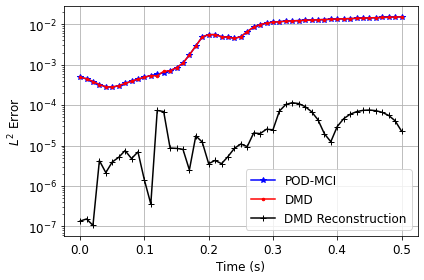

In [38]:
print(f"Computing DMD of POD Predictions...")
dmd_list = []

if "sphere" in problem_name:
    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = DMD(svd_rank=tau, opt=True).fit(X_pod[i])
        dmd_list.append(dmd)
    t_end = time.time()

elif "slab" in problem_name:
    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), [13, 26])
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()

elif "twigl" in problem_name:
    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), [11, 21])
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()

else:
    width = 12
    partitions = np.arange(width, 300, width)
    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), partitions)
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()

print(f"Average DMD construction time: {(t_end-t_start)/len(dmd_list):.3e} s")

# Compute errors
dmd_errors = np.zeros(len(dmd_list))
for i in range(len(dmd_list)):
    x_dmd = dmd_list[i].reconstructed_data
    dmd_errors[i] = norm(X_test[i]-x_dmd)/norm(x_dmd)

# Reconstruct worst POD result
x_dmd = dmd_list[argmax].reconstructed_data
dmd_step_errors = norm(x_test-x_dmd, axis=1)/norm(x_test, axis=1)
reconstruction_errors =  dmd_list[argmax].snapshot_errors

plot_dmd_errors(dataset.times, pod_step_errors,
                dmd_step_errors, reconstruction_errors,
                xlabel=xlabel)

# Print DMD results
msg = f"===== Summary of {len(pod_errors)} DMD Models ====="
header = "=" * len(msg)
print("\n".join(["", header, msg, header]))
print(f"Number of Snapshots:\t{len(X_pod[0])}")
n_modes = dmd_list[argmax].n_modes
if isinstance(n_modes, list):
    n_modes = sum(n_modes)
print(f"Number of DMD Modes:\t{n_modes}")
print(f"Average DMD Error:\t{np.mean(dmd_errors):.3e}")
print(f"Maximum DMD Error:\t{np.max(dmd_errors):.3e}")
print(f"Minimum DMD Error:\t{np.min(dmd_errors):.3e}")

if 'lra' in problem_name:
    times, alphas = [], []
    dt = np.diff(dataset.times)[0]
    dmd: PartitionedDMD = dmd_list[argmax]
    for i, sub_dmd in enumerate(dmd_list[argmax]):
        t = dmd.partial_time_interval(i)
        midpt = t['t0'] + (t['tend']-t['t0'])//2
        times.append(dataset.times[midpt])

        omegas = np.log(sub_dmd.eigvals).real/dt
        idx = np.argsort(sub_dmd.amplitudes.real)[::-1]
        alphas.append(omegas[idx[0]])

    plt.figure()
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Time-Eigenvalue (s$^{-1}$)", fontsize=12)
    plt.plot(times, alphas, '-*b')
    plt.grid(True)
    plt.tight_layout()